## Section 03: Flop Equity Calculation
**Abstract**: In this notebook, we calculate the flop equity for each player's hand based on various engineered features derived from the hole cards and flop cards. This involves grouping hands by these features and estimating the equity for each group, similar to the approach used for pre-flop equity calculations.

In [1]:
# Imports
import pandas as pd
from deuces import Evaluator

**Flop Equity Features**: We estimate flop equity by grouping hands based on other features that can be engineered from the hole cards and flop cards. These features include:
- Hand Classification: Pair, High Card, etc.
- Pocket Pair: Boolean indicating if the hole cards are a pocket pair.
- Suited: Boolean indicating if the hole cards are suited.
- Flush Potential: Complete, Open, Backdoor, or None.
- Straight Potential: Complete, Open, Gut-shot, Backdoor, or None.
- Overcards: Number of hole cards that are higher than the highest card on the flop.
- Board Texture: Number of unique suits on the board.
- Board Connectivity: Number of cards required to complete a straight on the board.

Functions to compute these features are defined in the `src.helpers` module.

In [2]:
# load long-form dataframe
hands_long = pd.read_pickle('../data/hands_long.pkl')
# remove all unnecessary columns, we are only interested in the player's hole cards, flop cards, flop evaluation, and showdown order
flop_hands = hands_long[[
    'hole_', 'flop', 'flop_eval_', 'showdown_order_'
]].copy()
# preview data
flop_hands.head()

,hole_,flop,flop_eval_,showdown_order_
0,"[533255, 67144223]","[16795671, 33573149, 16783383]",4310,2
1,"[4212241, 164099]","[268454953, 1082379, 134253349]",6322,4
2,"[268454953, 8394515]","[67119647, 81922, 1065995]",6428,5
3,"[8406803, 8398611]","[268446761, 4204049, 4212241]",3018,4
4,"[16787479, 279045]","[268454953, 4212241, 73730]",6588,8


In [ ]:
from src.helpers import hand_classification, is_pocket_pair, is_suited, flush_potential, straight_potential, overcards, board_texture, board_connectivity

# add engineered features for flop equity calculation
flop_hands['hand_class'] = flop_hands['flop_eval_'].apply(
    hand_classification
)
flop_hands['pocket_pair'] = flop_hands['hole_'].apply(is_pocket_pair)
flop_hands['suited'] = flop_hands['hole_'].apply(is_suited)
flop_hands['flush_potential'] = flop_hands[['hole_', 'flop']].apply(
    lambda row: flush_potential(row['hole_'], row['flop']),
    axis=1
)
flop_hands['straight_potential'] = flop_hands[['hole_','flop']].apply(
    lambda row: straight_potential(row['hole_'], row['flop']),
    axis=1
)
flop_hands['overcards'] = flop_hands[['hole_','flop']].apply(
    lambda row: overcards(row['hole_'], row['flop']),
    axis=1
)
flop_hands['board_texture'] = flop_hands['flop'].apply(board_texture)
flop_hands['board_connectivity'] = flop_hands['flop'].apply(board_connectivity)
# drop unnecessary columns
flop_hands = flop_hands.drop(columns=['hole_', 'flop', 'flop_eval_'])
# preview data
flop_hands.head()

Now we need to account for different player counts, from 2 to 9 players. We can do this differently from the pre-flop equity calculation, since we don't need to merge on any features. We can simply replicate the dataframe for each player count and assign the player count to a new column.

In [4]:
# multiply by number of players to account for different player counts
flop_hands = pd.concat([flop_hands.assign(players=players) for players in range(2,10)], ignore_index=False)
# we should have 900k * 8 = 7.2 million rows now
flop_hands.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7200000 entries, 0 to 899999
Data columns (total 10 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   showdown_order_     int64 
 1   hand_class          int64 
 2   pocket_pair         bool  
 3   suited              bool  
 4   flush_potential     object
 5   straight_potential  object
 6   overcards           int64 
 7   board_texture       int64 
 8   board_connectivity  object
 9   players             int64 
dtypes: bool(2), int64(5), object(3)
memory usage: 508.1+ MB


Just like in the pre-flop equity calculation, we need to compute the total number of hands to consider for each player count, as well as the number of times a hand would win at showdown given its showdown order and player count. We can use the same combinatorial methods defined in the `src.helpers` module.

In [5]:
from src.helpers import total_hands, wins

flop_hands['total_hands'] = flop_hands['players'].apply(total_hands)

flop_hands['wins'] = flop_hands[['showdown_order_','players']].apply(
    lambda row: wins(row['showdown_order_'], row['players']),
    axis=1
)
# preview data
flop_hands.head()

,showdown_order_,hand_class,pocket_pair,suited,flush_potential,straight_potential,overcards,board_texture,board_connectivity,players,total_hands,wins
0,2,8,False,False,None,Gut-shot,1,2,Low,2,8,7
1,4,9,False,False,Backdoor,Backdoor,0,2,Low,2,8,5
2,5,9,False,False,Backdoor,Backdoor,1,2,Low,2,8,4
3,4,7,True,False,Backdoor,Backdoor,0,2,Low,2,8,5
4,8,9,False,False,Backdoor,Gut-shot,0,2,Low,2,8,1


In [6]:
# aggregate to get total wins and total hands for each condition
flop_equity = flop_hands.groupby(
    ['players', 'hand_class', 'pocket_pair', 'suited', 'flush_potential',
     'straight_potential', 'overcards', 'board_texture', 'board_connectivity']
).agg(
    total_wins=('wins', 'sum'),
    total_hands=('total_hands', 'sum'),
).reset_index()
# compute win frequency
flop_equity['win_freq'] = flop_equity['total_wins'] / flop_equity['total_hands']
# preview data
flop_equity.head()

,players,hand_class,pocket_pair,suited,flush_potential,straight_potential,overcards,board_texture,board_connectivity,total_wins,total_hands,win_freq
0,2,1,False,True,Complete,Complete,0,1,Low,40,40,1.0
1,2,1,False,True,Complete,Complete,1,1,Low,16,16,1.0
2,2,1,False,True,Complete,Complete,1,1,Medium,8,8,1.0
3,2,1,False,True,Complete,Complete,2,1,Medium,24,24,1.0
4,2,2,False,False,None,Backdoor,0,3,Low,104,104,1.0


In [7]:
# save locally
flop_equity.to_pickle('../data/flop_equity.pkl')
flop_equity.to_csv('../data/flop_equity.csv', index=False)

Lets also create a heatmap to visualize the average estimated flop equity by hand class and number of players.

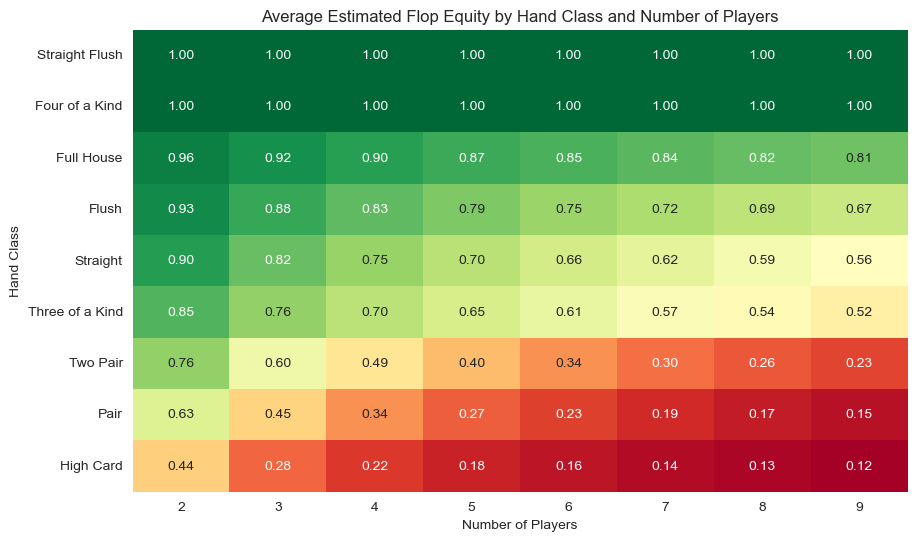

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

evaluator = Evaluator()

# Pivot for heatmap: win_freq by hand_class and players
pivot = flop_equity.pivot_table(
    index='hand_class', columns='players', values='win_freq', aggfunc='mean'
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot, annot=True, fmt=".2f", cmap='RdYlGn', cbar=False)
plt.title("Average Estimated Flop Equity by Hand Class and Number of Players")
plt.ylabel("Hand Class")
plt.xlabel("Number of Players")

hand_class_labels = [evaluator.class_to_string(cls) for cls in pivot.index]
ax.set_yticklabels(hand_class_labels, rotation=0)
plt.savefig('../figures/flop_equity.png', dpi=300)
plt.show()

**Conclusion**: In this notebook, we successfully calculated the flop equity for various hand conditions by engineering relevant features from the hole and flop cards. We grouped the hands based on these features and estimated the equity for each group, similar to our approach for pre-flop equity calculations. The resulting flop equity data can be used to inform strategic decisions in poker gameplay. We also visualized the average estimated flop equity by hand class and number of players using a heatmap, providing insights into how different hand types perform across varying player counts.